In [29]:
# Import the inverse of the cumulative distribution function of the standard gaussian called ndtri
from scipy.special import ndtri
# Imported the norm library which can compute cdf of a standard gaussian
from scipy.stats import norm
# Necessary for finding values of r(Psi) for arbitrary Psi
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:

def check_feller_condition(
    revert_speed: float, historical_average: float, vol_of_vol: float
):
    """
    Feller condition ensures the CIR process never goes negative
    
    Args:
        revert_speed (float) : 
        historical average (float) :
        vol_of_vol (float) :
    Returns:
        check_result (bool) : 1 if passed, 0 if test fails
    """
    if 2 * revert_speed * historical_average > vol_of_vol ** 2:
        return 1
    else:
        return 0


In [12]:
def conditional_expectation_of_vol_process(theta, v0, kappa, T):
    return theta + (v0 - theta)*np.exp(-1*kappa*T)

def conditional_variance_of_vol_process(theta, v0, kappa, T, epsilon):
    a = np.exp(-1*kappa*T)
    b = (v0/kappa)*(epsilon**2)
    c = (theta/(2*kappa))*(epsilon**2)
    return b*(a - a**2)+c*((1-a)**2)

def conditional_expectation_ln_stock_process(theta, v0, ln_x0, kappa, T):
    a = np.exp(-1*kappa*T)
    return ln_x0 + (1/(2*kappa))*(theta - v0)*(1-a) - (theta*T)/2

def omega_1(theta, kappa, epsilon, rho, T):
    a = np.exp(-1*kappa*T)
    t1 = (epsilon**2)*(a**2)
    t2 = 4*a*((1+kappa*T)*(epsilon**2) - 2*rho*kappa*epsilon*(2+kappa*T) + 2*(kappa**2))
    t3 = (2*kappa*T - 5)*(epsilon**2) 
    t4 = 8*rho*kappa*epsilon*(kappa*T-2)
    t5 = 8*(kappa**2)*(kappa*T-1)
    return t1+t2+t3-t4+t5


def omega_2(theta, kappa, epsilon, rho, T):
    a = np.exp(-1*kappa*T)
    t1 = -1*(a*epsilon)**2
    t2 = 2*a*(-kappa*T*(epsilon**2)+2*rho*epsilon*kappa*(1+kappa*T)-2*(kappa**2))
    t3 = epsilon**2 - 4*kappa*rho*epsilon + 4*(kappa**2)
    return t1+t2+t3

def omega_3(theta, kappa, epsilon, rho, T):
    a = np.exp(-1*kappa*T)
    t1 = a**2 + (4*kappa*rho - epsilon)/epsilon
    t2 = 2*kappa*a*(T - (2*rho/epsilon)*(1+kappa*T))
    return t1+t2
    
def omega_4(theta, kappa, epsilon, rho, T):
    a = np.exp(-1*kappa*T)
    return a*(1-kappa*T+2*rho*T*(kappa**2)/epsilon) - a**2

def conditional_variance_log_stock(theta, kappa, epsilon, rho, v0, T):
    _omega1 = omega_1(theta, kappa, epsilon, rho, T)
    _omega2 = omega_2(theta, kappa, epsilon, rho, T)
    a = theta/(8*(kappa**3))
    b = v0/(4*(kappa**3))
    return a*_omega1 + b*_omega2


In [24]:
CACHED_FUNCTIONS_EXPORT_LOCATION = "./heston_cache.csv"
SMALLEST_TIME_STEP = (
    1.0 / 252.0
)  # 1 day out of 252 trading days per year (on average)

############ HESTON PATH GENERATION PARAMETERS #############
# These can be found in the Leif Andersen "Efficient Simulation of the Heston Stochastic Volatility Model"
# paper, in the Numerical Tests section, Table 1, CASE 1
REVERT_SPEED = 0.5
HISTORICAL_MEAN = 0.04
VOL_OF_VOL = 1
CORRELATION = -0.9
MATURITY = 10  # YEARS
INITIAL_STOCK_PRICE = 100
PSI_CRITICAL = 1.5
GAMMA_1 = 0.5
GAMMA_2 = 0.5
NUMBER_OF_SIMULATIONS = int(1e6)  # 1 million trajectories is used by Leif Andreson
FIXED_INTEREST_RATE = 0.01

In [40]:
check_feller_condition(revert_speed = REVERT_SPEED, historical_average = HISTORICAL_MEAN, vol_of_vol = VOL_OF_VOL)

0

The Feller condition does not pass, and this mean using an Euler or Truncated Gaussian discretization would give very bad convergence

Implementation is following https://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/1826b88b152e65a7c12574b000347c74/$FILE/LeifAndersenHeston.pdf

In [14]:
# Truncated Gaussian Implmentation of the Heston Model \ MOMENT - MATCHING SCHEME
class Heston_TG:
    def __init__(
        self,
        historical_vol,
        revert_speed,
        vol_of_vol,
        correlation,
        initial_vol,
        initial_stock_price,
        time_span,
        steps_per_year,
    ):

        self.df_cache = pd.read_csv(CACHED_FUNCTIONS_EXPORT_LOCATION)
        self.Psi_domain = self.df_cache["Psi"].values
        self.f_mu = self.df_cache["f_mu(Psi)"].values
        self.f_sigma = self.df_cache["f_sigma(Psi)"].values
        self.historical_vol = historical_vol
        self.revert_speed = revert_speed
        self.vol_of_vol = vol_of_vol
        self.correlation = correlation
        self.initial_vol = initial_vol
        self.initial_stock_price = initial_stock_price
        self.N = time_span * steps_per_year
        self.time_step = 1.0 / steps_per_year
        self.time_step_factor = np.exp(-1 * self.time_step * revert_speed)
        self.gamma_1 = GAMMA_1
        self.gamma_2 = GAMMA_2
        self.k0 = (
            -1
            * self.correlation
            * self.revert_speed
            * self.historical_vol
            * self.time_step
            / (self.vol_of_vol)
        )
        self.k1 = (
            self.gamma_1
            * self.time_step
            * (self.revert_speed * self.correlation / self.vol_of_vol - 0.5)
            - self.correlation / self.vol_of_vol
        )
        self.k2 = (
            self.gamma_2
            * self.time_step
            * (self.revert_speed * self.correlation / self.vol_of_vol - 0.5)
            + self.correlation / self.vol_of_vol
        )
        self.k3 = self.gamma_1 * self.time_step * (1 - self.correlation ** 2)
        self.k4 = self.gamma_2 * self.time_step * (1 - self.correlation ** 2)

    def take_closest(self, myList, myNumber):
        """
        Assumes myList is sorted. Returns closest value to myNumber.

        If two numbers are equally close, return the smallest number.
        """
        pos = bisect_left(myList, myNumber)
        if pos == 0:
            return myList[0]
        if pos == len(myList):
            return myList[-1]
        before = myList[pos - 1]
        after = myList[pos]
        if after - myNumber < myNumber - before:
            return after
        else:
            return before

    def compute_m_parameter(self, current_vol):
        return (
            self.historical_vol
            + (current_vol - self.historical_vol) * self.time_step_factor
        )

    def compute_s2_parameter(self, current_vol):
        _f1 = (
            (1 - self.time_step_factor)
            * current_vol
            * (self.vol_of_vol ** 2)
            * self.time_step_factor
            / self.revert_speed
        )
        _f2 = (
            (1 - self.time_step_factor) ** 2
            * self.historical_vol
            * self.vol_of_vol ** 2
            / (2 * self.revert_speed)
        )
        return _f1 + _f2

    def generate_tg_paths(self):
        
        # Generates a single trajectory of TG Heston up to maturity
        
        volatility_vector = [self.initial_vol]
        stock_log_vec = [np.log(self.initial_stock_price)]
        
        for i in range(self.N):
            m = self.compute_m_parameter(volatility_vector[i])
            s_squared = self.compute_s2_parameter(volatility_vector[i])
            _Psi = s_squared / (m ** 2)
            cached_Psi_index = np.argwhere(self.Psi_domain == self.take_closest(self.Psi_domain, _Psi))[0][0]
            _mu = m * self.f_mu[cached_Psi_index]
            _sigma = self.f_sigma[cached_Psi_index] * np.sqrt(s_squared)
            u_v = np.random.uniform()
            z_v = ndtri(u_v)
            volatility_vector.append(max(0, _mu + _sigma * z_v))

        for i in range(self.N - 1):
            _ln_increment_stock = (
                (self.k0
                + self.k1 * volatility_vector[i]
                + self.k2 * volatility_vector[i + 1])
                + np.sqrt(
                    self.k3 * volatility_vector[i] + self.k4 * volatility_vector[i + 1]
                )
                * np.random.normal()
            )
            new_log_stock = stock_log_vec[i] + _ln_increment_stock
            stock_log_vec.append(new_log_stock)

        return volatility_vector[:-1], stock_log_vec



In [41]:

class Heston_QE:
    def __init__(
        self,
        historical_vol,
        revert_speed,
        vol_of_vol,
        correlation,
        initial_vol,
        initial_stock_price,
        time_span,
        steps_per_year,
    ):

        self.historical_vol = historical_vol
        self.revert_speed = revert_speed
        self.vol_of_vol = vol_of_vol
        self.correlation = correlation
        self.initial_vol = initial_vol
        self.initial_stock_price = initial_stock_price
        self.N = time_span * steps_per_year
        self.time_step = 1.0 / steps_per_year
        self.time_step_factor = np.exp(-1 * self.time_step * revert_speed)
        self.Psi_critical = PSI_CRITICAL
        self.gamma_1 = GAMMA_1
        self.gamma_2 = GAMMA_2
        self.k0 = (
            -1
            * self.correlation
            * self.revert_speed
            * self.historical_vol
            * self.time_step
            / (self.vol_of_vol)
        )
        self.k1 = (
            self.gamma_1
            * self.time_step
            * (self.revert_speed * self.correlation / self.vol_of_vol - 0.5)
            - self.correlation / self.vol_of_vol
        )
        self.k2 = (
            self.gamma_2
            * self.time_step
            * (self.revert_speed * self.correlation / self.vol_of_vol - 0.5)
            + self.correlation / self.vol_of_vol
        )
        self.k3 = self.gamma_1 * self.time_step * (1 - self.correlation ** 2)
        self.k4 = self.gamma_2 * self.time_step * (1 - self.correlation ** 2)

    def compute_m_parameter(self, current_vol):
        return (
            self.historical_vol
            + (current_vol - self.historical_vol) * self.time_step_factor
        )

    def compute_s2_parameter(self, current_vol):
        _f1 = (
            (1 - self.time_step_factor)
            * current_vol
            * (self.vol_of_vol ** 2)
            * self.time_step_factor
            / self.revert_speed
        )
        _f2 = (
            (1 - self.time_step_factor) ** 2
            * self.historical_vol
            * self.vol_of_vol ** 2
            / (2 * self.revert_speed)
        )
        return _f1 + _f2

    def compute_b_qe_parameter(self, Psi):
        return np.sqrt(2 / Psi - 1 + np.sqrt(2 / Psi) * np.sqrt(2 / Psi - 1))

    def compute_a_qe_parameter(self, m, b):
        return m / (1 + b * b)

    def compute_upper_boundary_func(self, u, p, beta):
        if u <= p:
            return 0
        else:
            return (1 / beta) * np.log((1 - p) / (1 - u))

    def compute_p_qe_parameter(self, Psi):
        return (Psi - 1) / (Psi + 1)

    def compute_beta_qe_parameter(self, m, Psi):
        return 2 / (m * (1 + Psi))

    def compute_volatility_vector(self):

        volatility_vector = [self.initial_vol]
        for i in range(self.N):
            m = self.compute_m_parameter(volatility_vector[i])
            s_squared = self.compute_s2_parameter(volatility_vector[i])
            _Psi = s_squared / (m * m)
            u_v = np.random.uniform()
            if _Psi <= self.Psi_critical:
                b = self.compute_b_qe_parameter(_Psi)
                a = self.compute_a_qe_parameter(m, b)
                z_v = ndtri(u_v)
                volatility_vector.append(a * (b + z_v) ** 2)
            elif _Psi > self.Psi_critical:
                beta = self.compute_beta_qe_parameter(m, _Psi)
                p = self.compute_p_qe_parameter(_Psi)
                _new_val = self.compute_upper_boundary_func(u_v, p, beta)
                volatility_vector.append(_new_val)

        return volatility_vector

    def generate_qe_paths(self):

        volatility_vector = self.compute_volatility_vector()
        #stock_history = [self.initial_stock_price]
        stock_log_vec = [np.log(self.initial_stock_price)]
        
        for i in range(self.N - 1):
            current_vol = volatility_vector[i]
            future_vol = volatility_vector[i+1]
            _ln_increment_stock = (
                (self.k0
                + self.k1 * current_vol
                + self.k2 * future_vol)
                + np.sqrt(
                    self.k3 * current_vol + self.k4 * future_vol
                )
                * np.random.normal()
            )
            new_log_stock = stock_log_vec[i] + _ln_increment_stock
            stock_log_vec.append(new_log_stock)
            #stock_history.append(np.exp(new_log_stock))

        return volatility_vector[:-1], stock_log_vec


In [17]:
steps_per_year = 32

In [43]:
qe_path_generator = Heston_QE(
        historical_vol=HISTORICAL_MEAN,
        revert_speed=REVERT_SPEED,
        vol_of_vol=VOL_OF_VOL,
        correlation=CORRELATION,
        initial_vol=HISTORICAL_MEAN,
        initial_stock_price=INITIAL_STOCK_PRICE,
        time_span= MATURITY,
        steps_per_year= steps_per_year,
    )

In [55]:
NPaths = int(1e4)
Nsteps = MATURITY*steps_per_year
volVector = np.zeros((Nsteps, NPaths))
logStockVector = np.zeros((Nsteps, NPaths))
for i in tqdm(range(NPaths)):
    vol,log_stock = qe_path_generator.generate_qe_paths()
    volVector[:,i] = vol
    logStockVector[:,i] = log_stock

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:58<00:00, 55.95it/s]


In [56]:
timeArray = np.linspace(0,MATURITY, Nsteps)

In [57]:
cEvol = conditional_expectation_of_vol_process(theta = HISTORICAL_MEAN, v0 = HISTORICAL_MEAN, kappa = REVERT_SPEED, T = timeArray)

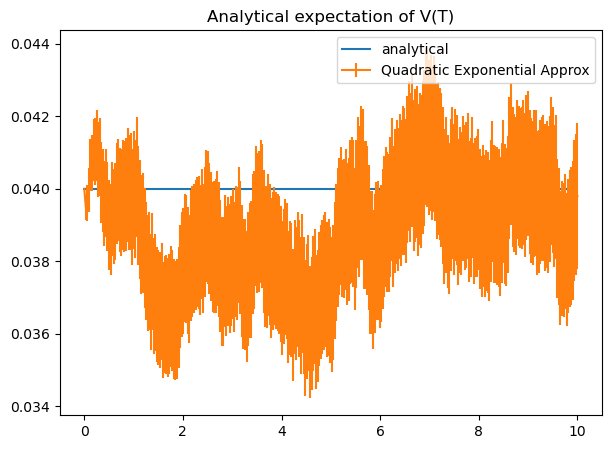

In [58]:
fig,ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(timeArray, cEvol, label='analytical')
ax.set_title('Analytical expectation of V(T)')
ax.errorbar(timeArray, np.mean(volVector,axis = 1), yerr = np.std(volVector,axis = 1)/np.sqrt(NPaths),label = 'Quadratic Exponential Approx')
ax.legend()


In [59]:

def conditional_variance_of_vol_process(theta, v0, kappa, T, epsilon):
    a = np.exp(-1*kappa*T)
    b = (v0/kappa)*(epsilon**2)
    c = (theta/(2*kappa))*(epsilon**2)
    return b*(a - a**2)+c*((1-a)**2)


In [60]:
cVvol = conditional_variance_of_vol_process(theta = HISTORICAL_MEAN, v0 = HISTORICAL_MEAN, kappa = REVERT_SPEED, T = timeArray, epsilon =VOL_OF_VOL)

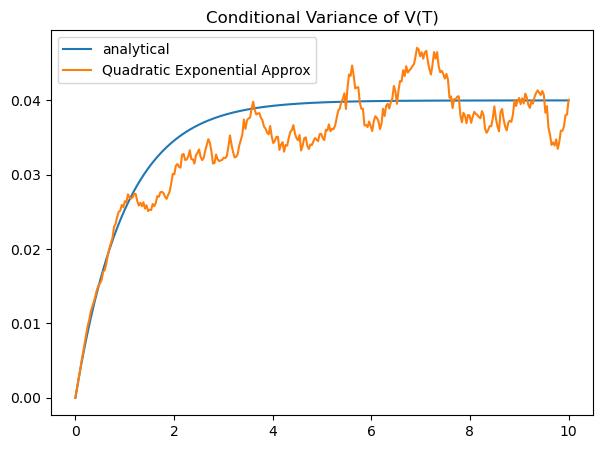

In [61]:
fig,ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(timeArray, cVvol, label='analytical')
ax.set_title('Conditional Variance of V(T)')
ax.plot(timeArray, np.var(volVector,axis = 1),label = 'Quadratic Exponential Approx')
ax.legend()


For only 10000 trajectories this is fairly good agreement